<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: This notebook is a work in progress & will be updated continuously until it's ready - 1 June 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

### What we're going to cover
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting (use the last timestep to predict the next timestep)
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin! Data source: https://www.coindesk.com/price/bitcoin

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [1]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-06-01 04:05:21--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-06-01 04:05:21--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc50a5a06edd78323effef5da4e0.dl.dropboxusercontent.com/cd/0/inline/BPlSRH0ivN36t6If7owL0K0Y7lWt92JdAU4F1qbR-ASIBs_zcdTCs12JIEKACfRSTYBOiG6HPEUDxP4AT7Zf7z1iw40vdLmuaXAKy0dtbSXHO6zf2n5uZtV8PFH5M72fdTxQr3BXLRaBzvxGiUGz7Nn4/file# [following]
--2021-06-01 04:05:21--  https://uc50a5a06edd78323effef5da4e0.dl.dropboxusercontent.com/cd/0/inline/

In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# TODO: time series often may not have very many samples (e.g. monthly = only 12 per year, daily = 365 per year... etc)
# Deep learning algorithms usually flourish with lots of data (1000's of samples)
len(df)

2787

In [5]:
# Only want closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [6]:
bitcoin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


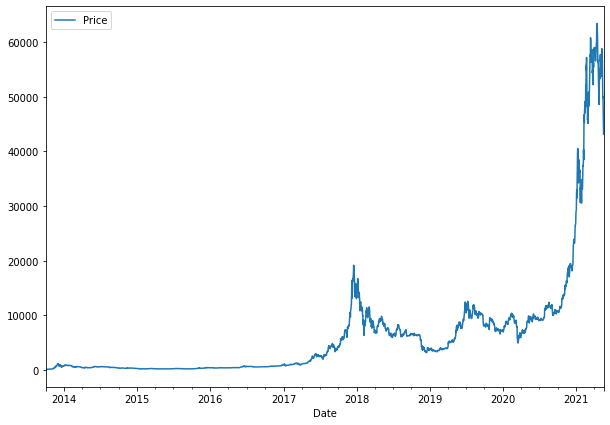

In [7]:
bitcoin_prices.plot(figsize=(10, 7));

In [8]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


### Importing time series as a CSV

In [9]:
# Importing with Python CSV - https://realpython.com/python-csv/
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

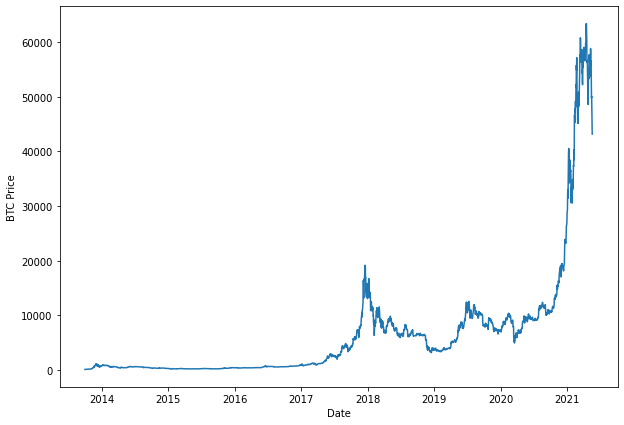

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, np.array(btc_price))
plt.xlabel("Date")
plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

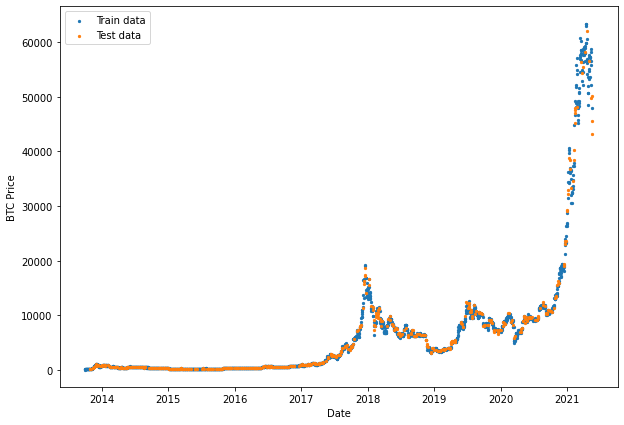

In [13]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

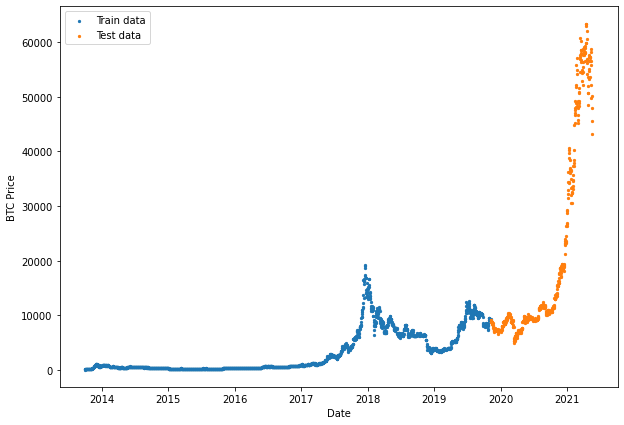

In [15]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

### TODO: Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

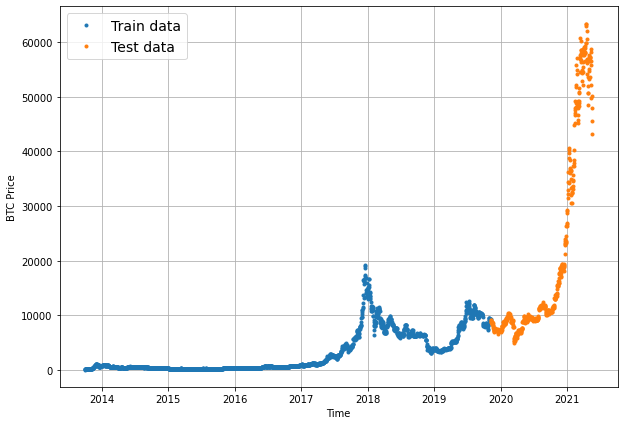

In [17]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format=".", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format=".", label="Test data")

## TODO: Modelling Experiments

* Baseline - naive forecasting
* Deep model - fully connected
  * Fully connected with different size window/horizon
  * -> How does a larger window effect a smaller horizon?
  * -> Model 1: horizon=1, window=7
  * -> Model 2: horizon=1, window=30
  * -> Model 3: horizon=7, window=30
* Sequence models
  * LSTM
  * Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

## Model 0: Naive forecast (baseline)

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [18]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

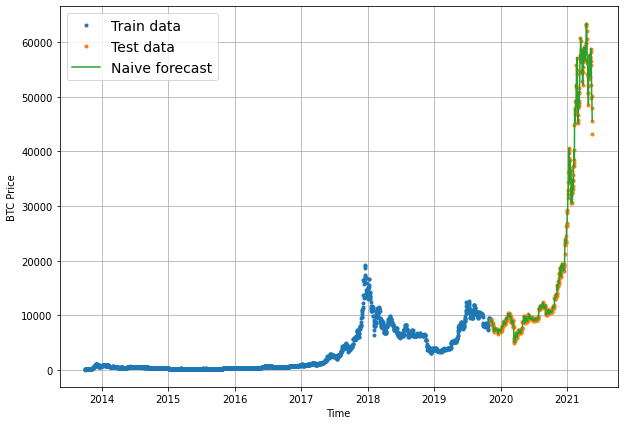

In [19]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format=".", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format=".", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label="Naive forecast");

The naive forecast looks like it's following the data well. But let's zoom in to take a better look.

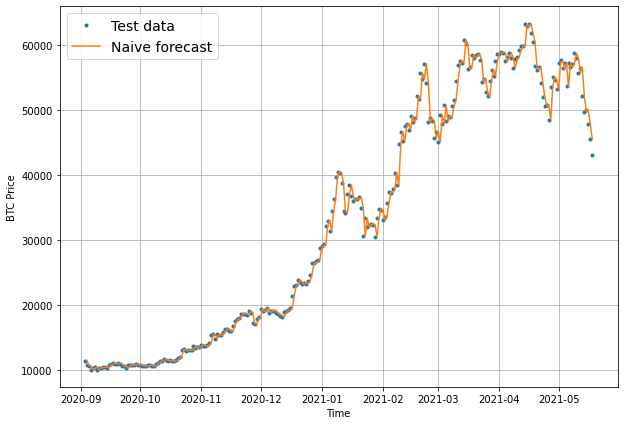

In [20]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=X_test, values=y_test, format=".", start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, label="Naive forecast");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

TK - add image for naive forecast (previous step to predict next step) 

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

TK - metrics for evaluating time series models: https://otexts.com/fpp2/accuracy.html

Scale-dependent erros (these can't be used to make comparisons between series that involve different units):
* MAE - a forecast method that minimises the MAE will lead to forecasts of the median
* RMSE - a forecast method that minimisies RMSE will lead to forecasts of the mean

Percentage errors: 
* MAPE (mean absolute percentage error) 
* sMAPE (recommended not to be used, though it is used in forecasting competitions)

Scaled errors (these are good when comparing forecasts accuracy across series with different units) - https://otexts.com/fpp2/accuracy.html#scaled-errors:
* MASE (mean absolute scaled error) 
  * There are two kinds of MASE, one for seasonal, one for non-seasonal data
    * "To take a non-seasonal example, consider the Google stock price..."


In [21]:
import tensorflow as tf

In [22]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## TODO: Mention other kinds of models which can be used for baselines

* TensorFlow Decision Forest
* Moving average
* Etc...
* Focused on pure TensorFlow kinds of models

## Windowing dataset

Why do we window?

TODO: We can turn our time series data into a **supervised learning problem**: use windows of the past to predict the future.

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=10, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # print(len(x)-1)
  # start = len(x) % window_size # account for data which doesn't fit into window, cut off at start
  # print(start)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
  # print(f"Window step:\n {window_step[-5:]}")
  # window_indexes = start + window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon+start-1)), axis=0).T # create 2D array of windows of size window_size
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:2], window_indexes[-2:]}")
  windowed_array = x[window_indexes] # get the original array indexed with windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [28]:
len(prices) % WINDOW_SIZE

1

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

### TODO: Make train/test splits after windowing, this helps with evaluation...

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
(2224, 2224, 556, 556)

(2224, 2224, 556, 556)

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## TODO: Make a modelling checkpoint... 

We need to save our model's best performance. 

In [34]:
import os

In [35]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## TODO: Model 1: Dense model (window = 7, horizon = 1)

* -> How does a larger window effect a smaller horizon?
* -> Model 1: horizon=1, window=7
* -> Model 2: horizon=1, window=30
* -> Model 3: horizon=7, window=30

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

In [37]:
len(train_windows), len(test_windows), len(full_windows)

(2224, 556, 2780)

In [38]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                              
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 9ms/step - loss: 780.3455 - val_loss: 2279.6528
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 247.6756 - val_loss: 1005.9993
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 188.4116 - val_loss: 923.2862
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 169.4340 - val_loss: 900.5872
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 165.0894 - val_loss: 895.2237
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 158.5210 - val_loss: 855.1984
INFO:tenso

In [39]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758


585.9757690429688

In [40]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.9510


568.9510498046875

### TODO: Making forecasts with a model

* We could make forecasts on the test windows, however this would end up in less prediction values than in the `y_test`
* Instead, we're going to make predictions on the full dataset windows 

In [41]:
def make_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.

  Input_data must be windowed version of whole dataset, otherwise forecasts won't match size of y_test.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model forecast on input_data from split_size-window_size onwards.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions 

In [42]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds)

556

In [43]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
       8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>

In [44]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4712}

In [45]:
# # Model 1 with 10 epochs & no block_reward variable
# {'mae': 763.506,
#  'mape': 3.3924627,
#  'mase': 1.3412685,
#  'mse': 1933137.0,
#  'rmse': 1390.3729}

# # Model 1 with 100 epochs & no block_reward variable
# {'mae': 568.5498,
#  'mape': 2.549229,
#  'mase': 0.99878454,
#  'mse': 1172587.6,
#  'rmse': 1082.8608}

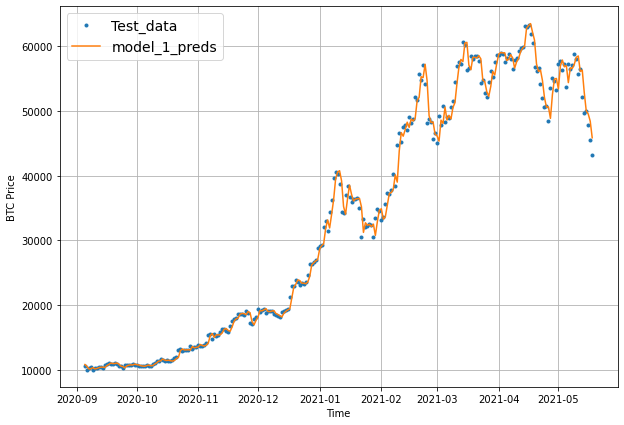

In [46]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format=".", start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, label="model_1_preds")

## TODO: Model 2: Dense (window = 30, horizon = 1)

Same model as model 1 except with different data.

TK - What happens if we make a larger window & horizon?

* TK - Window & horizon values are values you can tune...

In [47]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [48]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [49]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [50]:
# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/10
69/69 [==============================] - 0s 3ms/step - loss: 642.6427 - val_loss: 1336.2981
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 247.4091 - val_loss: 1096.2052
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 3/10
69/69 [==============================] - 0s 3ms/step - loss: 213.0392 - val_loss: 994.9751
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 4/10
69/69 [==============================] - 0s 3ms/step - loss: 176.5719 - val_loss: 2013.3877
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 193.2157 - val_loss: 901.2618
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 174.4803 - val_loss: 1297.8466
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 186.2701 - val_l

In [51]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 756.5145


756.5144653320312

In [52]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 756.5145


756.5144653320312

In [53]:
# Get forecast predictions
model_2_preds = make_forecast(model_2,
                              input_data=test_windows)

In [54]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 756.5144,
 'mape': 3.4486432,
 'mase': 1.3223946,
 'mse': 1840869.1,
 'rmse': 1356.7864}

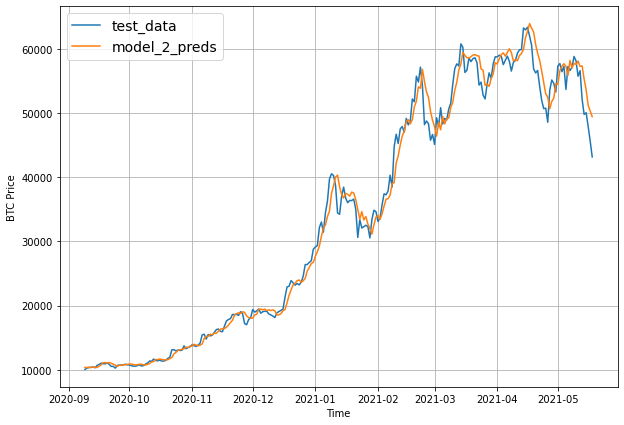

In [55]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.



In [56]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [58]:
# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/10
69/69 [==============================] - 0s 3ms/step - loss: 646.3671 - val_loss: 1837.6399
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 345.9967 - val_loss: 1711.8430
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 304.5448 - val_loss: 1678.5288
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 283.8305 - val_loss: 1459.5493
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 267.8029 - val_loss: 1688.3199
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 267.2786 - val_loss: 1785.9604
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 282.3341 - val

In [59]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1434.5563


1434.5562744140625

TODO: The error will be higher because we're predicting 7 steps at a time... the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days out...).

In [60]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_forecast(model_3,
                              input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9673.147 , 9942.092 , 9523.3955, 9135.803 , 9259.    , 9401.579 ,
        9419.822 ],
       [9443.995 , 9703.351 , 9250.772 , 9023.315 , 8985.831 , 9441.16  ,
        9268.931 ],
       [9426.777 , 9604.523 , 9231.978 , 9241.314 , 8835.734 , 9350.83  ,
        9207.692 ],
       [9591.581 , 9667.355 , 9352.048 , 9339.593 , 9061.151 , 9500.524 ,
        9345.751 ],
       [9455.072 , 9415.408 , 9199.38  , 9231.769 , 9050.712 , 9412.863 ,
        9474.887 ]], dtype=float32)>

In [61]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  686.0477 ,   551.22363,   566.97723,   781.6917 ,   765.66516,
          816.7739 ,   685.733  ,   603.82556,   657.87286,   788.69196,
          976.2626 ,   969.11237,  1036.1349 ,  1034.4282 ,   774.34125,
          458.61063,   278.5941 ,   321.98773,   247.57812,   231.3192 ,
          198.34451,    50.99951,   195.43297,   232.40807,   256.08252,
          302.06793,   316.72748,   257.01862,   311.06766,   254.4783 ,
          273.91672,   451.2696 ,   498.76694,   490.76764,   518.6963 ,
          505.93707,   525.24603,   407.9771 ,   400.69943,   180.955  ,
          236.00578,   219.62828,   206.04988,   144.09451,   162.81633,
          139.07121,   207.29973,   233.77477,   222.1741 ,   208.85666,
          215.99693,   220.95647,   257.19907,   260.33978,   332.02496,
          411.19147,   403.9979 ,   517.54987,   508.86258,   476.8522 ,
          364.2795 ,   419.97015,   420.40717,   406.66483,   561.2755 ,
          602.5834 ,   500.976  ,   363.1848

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [62]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [63]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1434.5563,
 'mape': 6.596248,
 'mase': 2.5527127,
 'mse': 6545260.0,
 'rmse': 1637.6982}

If we try to plot our multi-horizon predicts, we're going to get a funky looking plot.

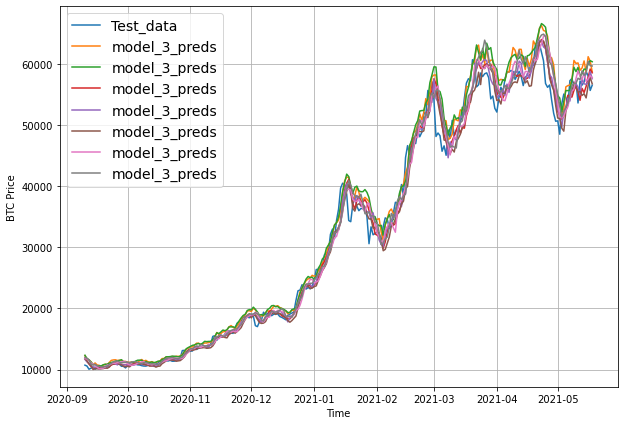

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds") 

TODO: what information do we lose through aggregated the predictions? E.g. going from 7 steps at a time to one step at a time? 

Again, we can fix this by aggregating our model's predictions.

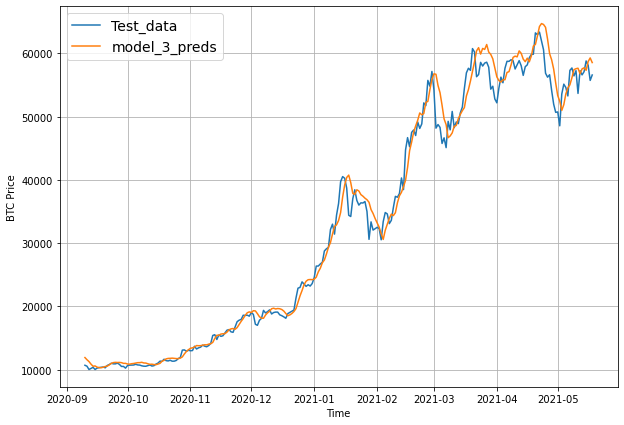

In [65]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="model_3_preds")

Which of our models is performing best so far?

In [66]:
model_1_results, model_2_results

({'mae': 568.95105,
  'mape': 2.5448983,
  'mase': 0.9994894,
  'mse': 1171743.8,
  'rmse': 1082.4712},
 {'mae': 756.5144,
  'mape': 3.4486432,
  'mase': 1.3223946,
  'mse': 1840869.1,
  'rmse': 1356.7864})

In [67]:
naive_results["mae"]

567.9802

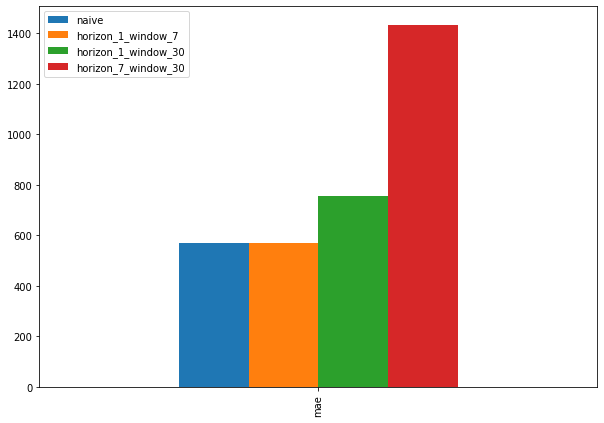

In [68]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Our naive model is performing best (it's very hard to beat a naive model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

## TODO: Model 4: Conv1D

In [69]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [70]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [71]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

TK - Since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = 1` - our model views one week of data at a time to predict the next day

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [72]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

In [73]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [74]:
# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels, 
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/10
70/70 [==============================] - 29s 4ms/step - loss: 573.8142 - val_loss: 1082.8295
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 2/10
70/70 [==============================] - 0s 3ms/step - loss: 183.5495 - val_loss: 990.6495
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 3/10
70/70 [==============================] - 0s 3ms/step - loss: 175.4528 - val_loss: 951.7764
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 4/10
70/70 [==============================] - 0s 3ms/step - loss: 166.1357 - val_loss: 854.8707
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 5/10
70/70 [==============================] - 0s 3ms/step - loss: 153.4303 - val_loss: 823.3082
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 6/10
70/70 [==============================] - 0s 3ms/step - loss: 144.2551 - val_loss: 779.6784
INFO:tensor

In [75]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            2816      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 746.7555


746.7554931640625

In [77]:
# Make predictions
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8932.787, 8784.207, 8833.94 , 8678.634, 8669.404, 8664.391,
       8599.435, 8454.063, 8427.286, 8400.136], dtype=float32)>

In [78]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 746.7555,
 'mape': 3.3394873,
 'mase': 1.3118426,
 'mse': 1694574.6,
 'rmse': 1301.7583}

## TODO: Model 5: RNN (LSTM)

TK (image) - make an image of inputs -> model -> output 

In [79]:
len(train_windows), len(train_labels)

(2224, 2224)

In [80]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu")(x)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
# x = layers.Dropout(0.05)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/10
70/70 [==============================] - 1s 7ms/step - loss: 923.8335 - val_loss: 999.7739
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 2/10
70/70 [==============================] - 0s 5ms/step - loss: 174.3591 - val_loss: 1059.5967
Epoch 3/10
70/70 [==============================] - 0s 4ms/step - loss: 169.0976 - val_loss: 915.7005
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 4/10
70/70 [==============================] - 0s 4ms/step - loss: 164.8597 - val_loss: 961.9780
Epoch 5/10
70/70 [==============================] - 0s 5ms/step - loss: 162.1378 - val_loss: 881.1057
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 6/10
70/70 [==============================] - 0s 4ms/step - loss: 154.4248 - val_loss: 1048.9911
Epoch 7/10
70/70 [==============================] - 0s 5ms/step - loss: 151.9672 - val_loss: 817.6928
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm

In [81]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Make predictions with our LSTM model
model_5_preds = make_forecast(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9002.466 , 8850.116 , 8907.427 , 8797.8955, 8680.045 , 8696.605 ,
       8652.487 , 8509.562 , 8473.361 , 8447.549 ], dtype=float32)>

In [83]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 848.7509,
 'mape': 3.756708,
 'mase': 1.4910203,
 'mse': 2154121.0,
 'rmse': 1467.6924}

# TODO: Make a multivariate time series 

Bitcoin price + halving events...

-> https://www.investopedia.com/bitcoin-halving-4843769

> Vigg_1991: For me … I use sensor data for predictions and forecasting … the toughest part of a time series has been .. when doing multivariate time series … some inputs may have larger scale compared to the target .. therefore do we de-trend all the data to keep them consistent or do we keep them them the way they are … because sometimes they lose the correlation between them once they are retreaded for prediction. How would you handle that ? Or is that important for deep learning predictions?

* inputs: larger scale compared to target
* detrend all the data to keep them consistent? Or keep the same way?
* sometimes they lose the correlation between them once they are de-trended 

In [84]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Now let's add another feature column, the block reward size (the amount of Bitcoin recevied by mining a block, this value halves every ~4 years and may be related to the price).

Source: https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [85]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values. 

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 **Note:** For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [86]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [87]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


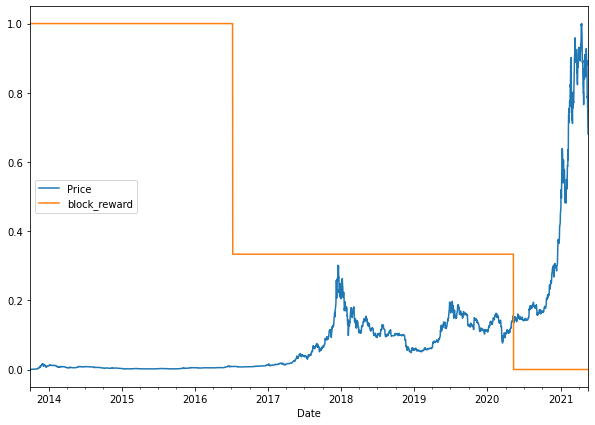

In [88]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

### TODO: Making a windowed dataset with pandas

TK - explain this

Let's make a windowed dataset with pandas.

In [89]:
HORIZON = 1
WINDOW_SIZE = 7

In [90]:
# Add windowed columns
bitcoin_prices_windowed = bitcoin_prices_block.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(i+1)
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
# Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE -> HORIZON
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas `dropna()` method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [91]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


What a good looking dataset, let's split it into train and test sets.

In [92]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [93]:
X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


### Model 6: Dense (multivariate time series)

Since `model_1` has performed the best so far, let's replicate its architecture and use it to train and make predictions on our multivariate time series data.

In [94]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the Naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=2, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
70/70 - 0s - loss: 524.0231 - val_loss: 1194.4154
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 2/100
70/70 - 0s - loss: 189.9447 - val_loss: 957.4072
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 3/100
70/70 - 0s - loss: 169.2797 - val_loss: 888.6912
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 4/100
70/70 - 0s - loss: 155.6410 - val_loss: 839.4843
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 5/100
70/70 - 0s - loss: 148.3778 - val_loss: 773.9180
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 6/100
70/70 - 0s - loss: 137.3192 - val_loss: 748.4239
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 7/100
70/70 - 0s - loss: 136.9815 - val_loss: 726.5155
INFO:tensorflow:Assets written to: model_experimen

In [95]:
# Evalaute
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 661.6104


661.6104125976562

In [96]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 567.0604


567.0604248046875

In [97]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8802.976, 8750.705, 9036.692, 8722.869, 8716.079, 8739.228,
       8648.347, 8488.017, 8439.643, 8514.621], dtype=float32)>

In [98]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.0604,
 'mape': 2.5321288,
 'mase': 0.9961681,
 'mse': 1154881.5,
 'rmse': 1074.6542}

## TODO: Make TensorFlow windows


In [99]:
BATCH_SIZE = 32

# Create TensorFlow datasets - from_tensor_slices is best when your data fits in memory: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels & features
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch (to speed up training)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # increasing the batch size should speed up training
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 8), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 8), (None,)), types: (tf.float32, tf.float32)>)

## TODO: Model 7: Dense (TensorFlow Windowed dataset)

In [100]:
tf.random.set_seed(42)

# Fit a model to the TensorFlow datasets
inputs = layers.Input(shape=(WINDOW_SIZE+1)) # add an extra dimension for the extra feature (block_reward)
x = layers.Dense(128, activation="relu")(inputs)
output = layers.Dense(HORIZON)(x)
model_7 = tf.keras.Model(inputs=inputs, outputs=output, name="model_7_TF_windows_with_block_reward")

# Compile
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_7.fit(train_dataset,
            epochs=500,
            verbose=0,
            validation_data=test_dataset,
            callbacks=[create_model_checkpoint(model_name=model_7.name)])

# Evaluate
model_7.evaluate(test_dataset)

INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written to: model_experiments/model_7_TF_windows_with_block_reward/assets
INFO:tensorflow:Assets written

575.9747924804688

In [101]:
# Load back in best model
model_7 = tf.keras.models.load_model("model_experiments/model_7_TF_windows_with_block_reward/")
model_7.evaluate(test_dataset)

18/18 [==============================] - 0s 2ms/step - loss: 564.9109


564.910888671875

## TODO: Model 8: N-BEATs algorithm

* Build model - Figure 1: https://arxiv.org/pdf/1905.10437.pdf
* Hyperparameters for N-Beats paper are available in Appendix D
* TODO: Does ensembling with different loss functions lead to some kind of pseudo uncertainty...?
* “N-BEATS is implemented and trained in TensorFlow”

In [102]:
# Create NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # TODO: are these the right dimensions?
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [103]:
# dummy_inputs = tf.expand_dims(tf.range(7) + 1, axis=0)
# dummy_inputs

In [104]:
# nbeats_block_layer(dummy_inputs)

In [105]:
# Demo the subtract layer...
X1 = tf.range(10) + 10
X2 = tf.range(10)
input_1 = layers.Input(shape=(10))
input_2 = layers.Input(shape=(10))
subtract_layer = layers.subtract([input_1, input_2])
subtract_model = tf.keras.Model(inputs=[input_1, input_2], outputs=subtract_layer)
print(X1)
print(X2)
subtract_model([X1, X2]).numpy()

tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)

In [106]:
# Instantiate input variables
WINDOW_SIZE = 7 # how far to lookback
HORIZON = 1 # how far to predict forward
BATCH_SIZE = 1024 # how many samples to look at per batch

# Values from paper (see Figure 1/Appendix D)
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [107]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [108]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [109]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [110]:
# Create TensorFlow dataset - from_tensor_slices is best when your data fits in memory: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels & features
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [111]:
tf.random.set_seed(42)

# Setup NBEATs Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Build stacks of blocks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") # https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
stack_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="Stack_Model")

# Compile
stack_model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])

# Fit
stack_model.fit(train_dataset,
                epochs=5000,
                validation_data=test_dataset,
                verbose=0,
                # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00688: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 01096: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 01196: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [112]:
stack_model.evaluate(test_dataset)

1/1 [==============================] - 0s 21ms/step - loss: 568.6333 - mae: 568.6333 - mse: 1154442.1250


[568.63330078125, 568.63330078125, 1154442.125]

In [113]:
stack_preds = make_forecast(stack_model, test_dataset)
stack_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8821.993, 8775.6  , 9029.339, 8740.713, 8778.378, 8764.709,
       8638.105, 8501.845, 8482.629, 8507.629], dtype=float32)>

In [114]:
stack_results = evaluate_preds(y_true=y_test,
                               y_pred=stack_preds)
stack_results

{'mae': 568.6333,
 'mape': 2.6049776,
 'mase': 0.9989312,
 'mse': 1154442.1,
 'rmse': 1074.4497}

In [115]:
# TODO: This will error out unless a "get_config()" method is implemented
stack_model.save("stack_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: stack_model/assets


INFO:tensorflow:Assets written to: stack_model/assets


# TODO: Create an ensemble

* We'll combine the predictions of 3 versions of `simple_model` and see what happens:
  * MAE
  * MSE
  * MAPE

In [116]:
%%time

tf.random.set_seed(42)

preds = {}
for loss_function in ["mae", "mse", "mape"]:
  print(f"Optimizing model by reducing: {loss_function}")

  # construct simple model
  simple_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
  ])

  simple_model.compile(loss=loss_function,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["mae", "mse"])

  simple_model.fit(train_dataset,
                   epochs=1000,
                   verbose=0,
                   validation_data=test_dataset,
                   # Stop when a model stops improving for ~200 epochs and lower the learning rate when improvement plateau's
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

  simple_model_preds = tf.squeeze(simple_model.predict(test_dataset))

  # Append predictions with target loss function to dictionary
  preds[loss_function] = simple_model_preds

Optimizing model by reducing: mae

Epoch 00594: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00694: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse

Epoch 00513: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00613: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape

Epoch 00235: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00335: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


CPU times: user 45.3 s, sys: 2.79 s, total: 48.1 s
Wall time: 39.1 s


In [117]:
ensemble_preds = np.array(list(preds.values()))
ensemble_preds.shape

(3, 556)

In [118]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 562.8058,
 'mape': 2.5378456,
 'mase': 0.9886939,
 'mse': 1142347.2,
 'rmse': 1068.8065}

### Plotting the variance (prediction intervals) of our ensemble

* See here for more: https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html#Continuous-Errors
* And here: https://stackoverflow.com/a/12958534/7900723 

In [119]:
# Get the variance of different ensemble preds (these are how much predictions vary accross loss metrics)
ensemble_var = tf.math.reduce_variance(ensemble_preds, axis=0)
ensemble_var[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([105.41138 , 664.4941  , 445.0857  , 161.63766 , 604.93536 ,
       750.4693  ,  10.178082, 151.72768 , 544.8608  , 165.43733 ],
      dtype=float32)>

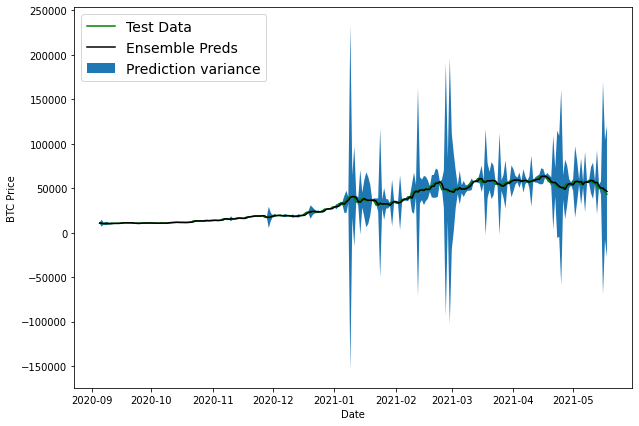

In [120]:
# Plot the variance/median of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

offset=300
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Preds")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (ensemble_median-ensemble_var)[offset:], 
                 (ensemble_median+ensemble_var)[offset:], label="Prediction variance")
plt.legend(loc="upper left", fontsize=14);

# TODO: Make future forecasts...

* UPTOHERE:
  * Make future forecasts with model (make a pred, append it to a window, make a pred, append it to a window, make a pred, append it to window
  * Measure the +/- of each pred (the prediction interval/uncertainty intervals)
  * Functionize future forecasting (getting future dates, predicting on X steps)

In [121]:
# TODO: Make forecasting work for one model and then make it work for an ensemble model 

In [122]:
bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [123]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [124]:
# TODO: Create TensorFlow windows for data

In [125]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_9.fit(X_all, y_all,
            epochs=10)

Epoch 1/10
87/87 [==============================] - 0s 2ms/step - loss: 705.2092
Epoch 2/10
87/87 [==============================] - 0s 2ms/step - loss: 294.3276
Epoch 3/10
87/87 [==============================] - 0s 2ms/step - loss: 263.1913
Epoch 4/10
87/87 [==============================] - 0s 2ms/step - loss: 275.9883
Epoch 5/10
87/87 [==============================] - 0s 2ms/step - loss: 255.7095
Epoch 6/10
87/87 [==============================] - 0s 2ms/step - loss: 242.3642
Epoch 7/10
87/87 [==============================] - 0s 2ms/step - loss: 246.4875
Epoch 8/10
87/87 [==============================] - 0s 2ms/step - loss: 217.4722
Epoch 9/10
87/87 [==============================] - 0s 2ms/step - loss: 250.9025
Epoch 10/10
87/87 [==============================] - 0s 2ms/step - loss: 232.3948


In [126]:
# Make predictions on the future

# List for new preds
future_forecast = []
last_window = y_all[-WINDOW_SIZE:] # get the last window of the training data
into_future = 14 # how far to predict into the future

for i in range(into_future):
  # Make a pred for the last window, then append the prediction, append it again, append it again
  pred = model_9.predict(tf.expand_dims(last_window, axis=0))
  print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(pred).numpy()}\n")
  future_forecast.append(tf.squeeze(pred).numpy())
  # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
  last_window = np.append(last_window, pred)[-WINDOW_SIZE:]

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55336.72265625

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55336.72265625] -> Prediction: 50097.125

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55336.72265625 50097.125     ] -> Prediction: 49777.33203125

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55336.72265625 50097.125      49777.33203125] -> Prediction: 47575.828125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55336.72265625
 50097.125      49777.33203125 47575.828125  ] -> Prediction: 46344.23828125

Predicting on: 
 [45604.61575361 43144.47129086 55336.72265625 50097.125
 49777.33203125 47575.828125   46344.23828125] -> Prediction: 44605.4765625

Predicting on: 
 [43144.47129086 55336.72265625 50097.125      49777.33203125

In [127]:
future_forecast[:10]

[55336.723,
 50097.125,
 49777.332,
 47575.83,
 46344.24,
 44605.477,
 45323.85,
 53863.52,
 48931.707,
 48922.555]

## TODO: Plot future forecasts

* Need: 
  * horizon # of dates in future
  * forecast

In [128]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [129]:
def get_future_dates(start_date, horizon=1, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  horizon: number of day to add onto start date for range (int)
  offset: if offset=1 (default), original date is not included, if offset=0, original date is included
  """
  return np.arange(start_date + np.timedelta64(offset, "D"), start_date + np.timedelta64(horizon+1, "D"), dtype="datetime64[D]")

In [130]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, horizon=into_future)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [131]:
# Add in extra timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55336.723, 50097.125, 49777.332, 47575.83 , 46344.24 ,
        44605.477, 45323.85 , 53863.52 , 48931.707, 48922.555, 45352.156,
        45170.227, 44108.586, 46919.94 ], dtype=float32))

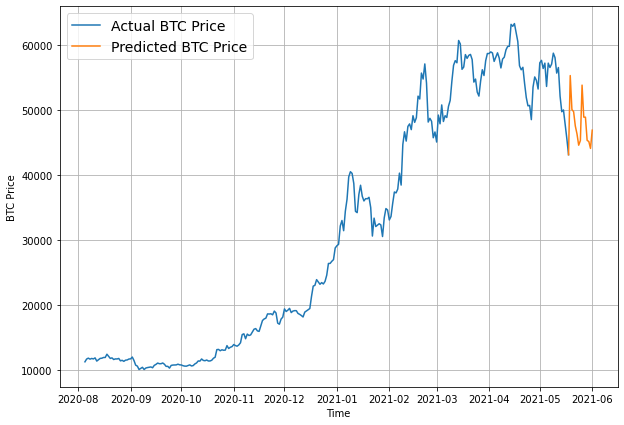

In [132]:
# TODO: if we predict far enough into the future we start to see what happens to our model's forecasts... (they begin to break down)
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, label="Predicted BTC Price")

## TODO: Plot uncertainty/prediction intervals on the future forecasts

UPTOHERE:
* To do this, make a function to make future forecasts in an ensemble format
* Return the future predictions as well as their variance(s) (from the ensemble)
* Turn X_all and y_all into a TensorFlow dataset? (faster)... time the ensemble training with/without TensorFlow datasets (see which is faster and by how much?)

In [133]:
# Create ensemble model to predict
# Train ensemble on all of training data
# Make predictions with ensemble model then plot the prediction intervals for each pred

In [134]:
# List for new preds
future_forecast = []
last_window = y_all[-WINDOW_SIZE:] # get the last window of the training data
into_future = 14 # how far to predict into the future

for i in range(into_future):
  # Make a pred for the last window, then append the prediction, append it again, append it again
  pred = model_9.predict(tf.expand_dims(last_window, axis=0))
  print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(pred).numpy()}\n")
  future_forecast.append(tf.squeeze(pred).numpy())
  # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
  last_window = np.append(last_window, pred)[-WINDOW_SIZE:]

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55336.72265625

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55336.72265625] -> Prediction: 50097.125

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55336.72265625 50097.125     ] -> Prediction: 49777.33203125

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55336.72265625 50097.125      49777.33203125] -> Prediction: 47575.828125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55336.72265625
 50097.125      49777.33203125 47575.828125  ] -> Prediction: 46344.23828125

Predicting on: 
 [45604.61575361 43144.47129086 55336.72265625 50097.125
 49777.33203125 47575.828125   46344.23828125] -> Prediction: 44605.4765625

Predicting on: 
 [43144.47129086 55336.72265625 50097.125      49777.33203125

In [135]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  for _ in range(into_future):
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    # print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(pred).numpy()}\n")
    # Append predictions to future_forecast
    print(future_pred)
    future_forecast.append(tf.squeeze(future_pred).numpy())
    print(future_forecast)
    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [136]:
%%time

# Create ensemble model to predict
tf.random.set_seed(42)

ensemble_forecasts = {}
for loss_function in ["mae", "mse", "mape"]:
  print(f"Optimizing model by reducing: {loss_function}")

  # construct simple model
  simple_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
  ], name=f"ensemble_{loss_function}") # name the model after the loss function

  simple_model.compile(loss=loss_function,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["mae", "mse"])

  simple_model.fit(X_all, y_all,
                   epochs=1000,
                   verbose=0,
                   # Stop when a model stops improving for ~200 epochs and lower the learning rate when improvement plateau's
                   # No validation data when training the model on all the data
                   batch_size=1024,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200, restore_best_weights=True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=100, verbose=1)])
  
  # # Save the model
  # simple_model.save(simple_model.name)

  # Make future forecasts with the target model
  future_forecast = make_future_forecast(values=y_all,
                                         model=simple_model, # use the current model
                                         into_future=into_future)

  print(future_forecast[:10])
  # Add the future forecasts with different loss functions to dictionary
  print(f"Adding future forecasts from model reducing: {loss_function}\n")
  ensemble_forecasts[loss_function] = future_forecast

Optimizing model by reducing: mae

Epoch 00369: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00604: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00704: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
[[56726.004]]
[56726.004]
[[51378.23]]
[56726.004, 51378.23]
[[50435.855]]
[56726.004, 51378.23, 50435.855]
[[50256.355]]
[56726.004, 51378.23, 50435.855, 50256.355]
[[47380.867]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867]
[[45721.035]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867, 45721.035]
[[44520.74]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867, 45721.035, 44520.74]
[[56835.75]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867, 45721.035, 44520.74, 56835.75]
[[50816.91]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867, 45721.035, 44520.74, 56835.75, 50816.91]
[[51079.02]]
[56726.004, 51378.23, 50435.855, 50256.355, 47380.867, 45721.035, 44520.74, 56835.75, 50816.91,

UPTOHERE:
* TODO: Can the above be combined into a simpler form?
* TODO: Future forecasts would of course have to be updated daily (there's new data every day...) and every time the model would have to be retrained to work with the future forecast
* TODO: Variance metrics look wild for forecasts prediction intervals... how can this be improved?

In [137]:
ensemble_forecasts

{'mae': [56726.004,
  51378.23,
  50435.855,
  50256.355,
  47380.867,
  45721.035,
  44520.74,
  56835.75,
  50816.91,
  51079.02,
  50144.406,
  46966.09,
  45993.695,
  45708.46],
 'mape': [56809.188,
  51623.25,
  48541.14,
  49912.336,
  47856.195,
  45656.95,
  44889.688,
  56873.832,
  51003.035,
  48083.53,
  49795.95,
  47756.332,
  45880.28,
  45987.25],
 'mse': [56849.406,
  51699.62,
  50413.07,
  49558.758,
  47089.094,
  45668.793,
  44335.766,
  56989.5,
  51499.973,
  50915.99,
  48853.117,
  46327.875,
  45816.902,
  45088.195]}

In [138]:
ensemble_forecasts_values = np.array(list(ensemble_forecasts.values()))

In [157]:
# Get median of ensemble forecasts
ensemble_forecasts_median = np.median(ensemble_forecasts_values, axis=0)
ensemble_forecasts_median

array([56809.188, 51623.25 , 50413.07 , 49912.336, 47380.867, 45668.793,
       44520.74 , 56873.832, 51003.035, 50915.99 , 49795.95 , 46966.09 ,
       45880.28 , 45708.46 ], dtype=float32)

In [158]:
ensemble_forecasts_mean = np.mean(ensemble_forecasts_values, axis=0)
ensemble_forecasts_mean

array([56794.863, 51567.03 , 49796.688, 49909.145, 47442.05 , 45682.26 ,
       44582.062, 56899.69 , 51106.64 , 50026.176, 49597.824, 47016.766,
       45896.957, 45594.637], dtype=float32)

In [160]:
tf.abs(ensemble_forecasts_mean - ensemble_forecasts_median)

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([ 14.324219 ,  56.21875  , 616.3828   ,   3.1914062,  61.183594 ,
        13.46875  ,  61.32422  ,  25.859375 , 103.60547  , 889.8125   ,
       198.125    ,  50.67578  ,  16.675781 , 113.82422  ], dtype=float32)>

In [150]:
ensemble_forecasts_values.shape

(3, 14)

In [147]:
# Get variance of ensemble forecasts
ensemble_forecasts_variance = tf.math.reduce_variance(ensemble_forecasts_values, axis=0)
ensemble_forecasts_variance

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([2.6405774e+03, 1.8795449e+04, 7.8828719e+05, 8.1112156e+04,
       9.9945930e+04, 7.7516974e+02, 5.3018652e+04, 4.2742646e+03,
       8.3129312e+04, 1.8913714e+06, 2.9753134e+05, 3.4136559e+05,
       5.3483765e+03, 1.4119467e+05], dtype=float32)>

In [152]:
ensemble_forecasts_std = tf.math.reduce_std(ensemble_forecasts_values, axis=0)
ensemble_forecasts_std

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([  51.386547,  137.0965  ,  887.8554  ,  284.80197 ,  316.14227 ,
         27.84187 ,  230.2578  ,   65.37786 ,  288.32153 , 1375.2714  ,
        545.46436 ,  584.265   ,   73.1326  ,  375.7588  ], dtype=float32)>

In [186]:
tf.abs(tf.reduce_min(ensemble_forecasts_values, axis=0) - tf.reduce_max(ensemble_forecasts_values, axis=0))

<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([ 123.40234,  321.39062, 1894.7148 ,  697.59766,  767.10156,
         64.08594,  553.9219 ,  153.75   ,  683.0625 , 2995.4883 ,
       1291.2891 , 1428.457  ,  176.79297,  899.0547 ], dtype=float32)>

In [177]:
ensemble_forecasts_median = np.insert(ensemble_forecasts_median, 0, y_all[-1])
ensemble_forecasts_median

array([43144.473, 56809.188, 51623.25 , 50413.07 , 49912.336, 47380.867,
       45668.793, 44520.74 , 56873.832, 51003.035, 50915.99 , 49795.95 ,
       46966.09 , 45880.28 , 45708.46 ], dtype=float32)

In [180]:
ensemble_forecasts_median[1:]

array([43144.473, 56809.188, 51623.25 , 50413.07 , 49912.336, 47380.867,
       45668.793, 44520.74 , 56873.832, 51003.035, 50915.99 , 49795.95 ,
       46966.09 , 45880.28 , 45708.46 ], dtype=float32)

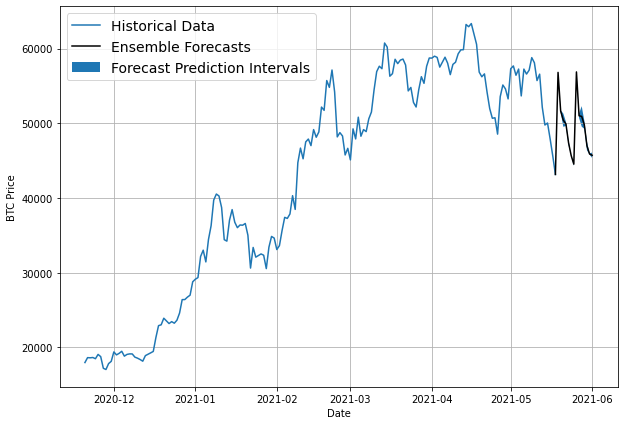

In [182]:
# Plot ensemble forecasts with variance
plt.figure(figsize=(10, 7))
offset = 2600
# plt.plot(bitcoin_prices.index[WINDOW_SIZE:], y_all, label="Historical Data")
plot_time_series(timesteps=bitcoin_prices.index[WINDOW_SIZE:], values=y_all, start=offset, label="Historical Data")
plt.plot(next_time_steps, ensemble_forecasts_median, "k-", label="Ensemble Forecasts")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(next_time_steps[1:],
                 (ensemble_forecasts_median[1:]-ensemble_forecasts_std),
                 (ensemble_forecasts_median[1:]+ensemble_forecasts_std),
                 label="Forecast Prediction Intervals")
plt.legend(fontsize=14);

In [190]:
tf.math.reduce_std(btc_price).numpy()

10885.894

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

In [231]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [232]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [233]:
# Add an extra day to our timesteps
btc_timesteps_turkey = np.array(bitcoin_prices.index)
# btc_timesteps_turkey = np.append(btc_timesteps_turkey, np.datetime64(btc_timesteps_turkey[-1]) + np.timedelta64(1, "D"))

In [234]:
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

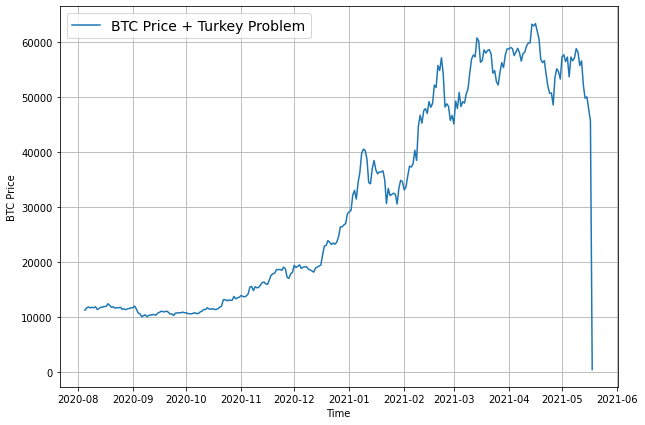

In [235]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, values=btc_price_turkey, label="BTC Price + Turkey Problem", start=2500)

In [236]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

With our updated data, we only changed 1 value.

Let's see how it effects our model.

In [237]:
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4712}

In [240]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=1,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

Epoch 1/100
70/70 [==============================] - 0s 3ms/step - loss: 563.0485 - val_loss: 1243.2610
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 179.3031 - val_loss: 1010.7814
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 170.7594 - val_loss: 935.6658
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 152.6640 - val_loss: 871.7413
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 147.3967 - val_loss: 957.0953
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 139.9457 - val_loss: 813.3171
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 137.5800 - val_loss: 792.1682
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 141.7923 - val_loss: 780.1077
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 134.9725 - val_loss: 1028.9510
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 146.1458 - val_loss: 829.3902
Epoch 11/100
70/70 [==============================] - 0s 2ms/step - loss: 133.9852 - val_loss: 918.8932
Epoch 12/100
70/70 [==============================] - 0s 2ms/step - loss: 125.9630 - val_loss: 964.0942
Epoch 13/100
70/70 [==============================] - 0s 2ms/step - loss: 127.7596 - val_loss: 770.4465
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 14/100
70/70 [==============================] - 0s 2ms/step - loss: 126.9266 - val_loss: 1237.5167
Epoch 15/100
70/70 [==============================] - 0s 2ms/step - loss: 129.2569 - val_loss: 805.7851
Epoch 16/100
70/70 [==============================] - 0s 2ms/step - loss: 121.8781 - val_loss: 706.0756
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 17/100
70/70 [==============================] - 0s 2ms/step - loss: 120.7525 - val_loss: 716.4655
Epoch 18/100
70/70 [==============================] - 0s 2ms/step - loss: 122.7997 - val_loss: 721.5082
Epoch 19/100
70/70 [==============================] - 0s 2ms/step - loss: 133.7090 - val_loss: 810.1750
Epoch 20/100
70/70 [==============================] - 0s 2ms/step - loss: 119.6328 - val_loss: 797.7311
Epoch 21/100
70/70 [==============================] - 0s 2ms/step - loss: 121.2415 - val_loss: 710.2468
Epoch 22/100
70/70 [==============================] - 0s 2ms/step - loss: 119.9312 - val_loss: 691.0756
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 23/100
70/70 [==============================] - 0s 2ms/step - loss: 130.2335 - val_loss: 837.7322
Epoch 24/100
70/70 [==============================] - 0s 2ms/step - loss: 126.0129 - val_loss: 668.8574
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 25/100
70/70 [==============================] - 0s 2ms/step - loss: 121.3818 - val_loss: 696.7709
Epoch 26/100
70/70 [==============================] - 0s 2ms/step - loss: 128.7534 - val_loss: 734.4456
Epoch 27/100
70/70 [==============================] - 0s 2ms/step - loss: 122.5292 - val_loss: 1013.7244
Epoch 28/100
70/70 [==============================] - 0s 2ms/step - loss: 115.4515 - val_loss: 700.8008
Epoch 29/100
70/70 [==============================] - 0s 2ms/step - loss: 116.8837 - val_loss: 661.2786
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 30/100
70/70 [==============================] - 0s 2ms/step - loss: 112.0017 - val_loss: 660.7883
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 31/100
70/70 [==============================] - 0s 2ms/step - loss: 116.0245 - val_loss: 906.5740
Epoch 32/100
70/70 [==============================] - 0s 2ms/step - loss: 116.7395 - val_loss: 673.5887
Epoch 33/100
70/70 [==============================] - 0s 2ms/step - loss: 117.0317 - val_loss: 722.2352
Epoch 34/100
70/70 [==============================] - 0s 2ms/step - loss: 120.9559 - val_loss: 685.6254
Epoch 35/100
70/70 [==============================] - 0s 2ms/step - loss: 110.4330 - val_loss: 693.7922
Epoch 36/100
70/70 [==============================] - 0s 2ms/step - loss: 115.7596 - val_loss: 846.8072
Epoch 37/100
70/70 [==============================] - 0s 2ms/step - loss: 115.2604 - val_loss: 657.9602
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 38/100
70/70 [==============================] - 0s 2ms/step - loss: 117.2842 - val_loss: 836.6794
Epoch 39/100
70/70 [==============================] - 0s 2ms/step - loss: 113.5778 - val_loss: 886.5338
Epoch 40/100
70/70 [==============================] - 0s 2ms/step - loss: 119.6850 - val_loss: 723.4863
Epoch 41/100
70/70 [==============================] - 0s 2ms/step - loss: 111.9374 - val_loss: 903.6814
Epoch 42/100
70/70 [==============================] - 0s 2ms/step - loss: 117.2674 - val_loss: 649.3455
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 43/100
70/70 [==============================] - 0s 2ms/step - loss: 113.2866 - val_loss: 663.0706
Epoch 44/100
70/70 [==============================] - 0s 2ms/step - loss: 113.1689 - val_loss: 646.8358
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 45/100
70/70 [==============================] - 0s 2ms/step - loss: 112.2128 - val_loss: 664.8189
Epoch 46/100
70/70 [==============================] - 0s 2ms/step - loss: 129.2279 - val_loss: 683.9905
Epoch 47/100
70/70 [==============================] - 0s 2ms/step - loss: 111.8071 - val_loss: 934.6192
Epoch 48/100
70/70 [==============================] - 0s 2ms/step - loss: 129.8489 - val_loss: 765.5577
Epoch 49/100
70/70 [==============================] - 0s 2ms/step - loss: 122.4883 - val_loss: 650.2750
Epoch 50/100
70/70 [==============================] - 0s 2ms/step - loss: 111.9430 - val_loss: 664.0247
Epoch 51/100
70/70 [==============================] - 0s 2ms/step - loss: 114.1849 - val_loss: 675.8277
Epoch 52/100
70/70 [==============================] - 0s 2ms/step - loss: 122.0807 - val_loss: 771.3733
Epoch 53/100
70/70 [==============================] - 0s 2ms/step - loss: 116.1520 - val_loss: 656.2681
Epoch 54/100
70/70 [==============================] - 0s 2ms/ste

INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 59/100
70/70 [==============================] - 0s 2ms/step - loss: 112.5338 - val_loss: 642.9720
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 60/100
70/70 [==============================] - 0s 2ms/step - loss: 108.6403 - val_loss: 655.8129
Epoch 61/100
70/70 [==============================] - 0s 2ms/step - loss: 110.2727 - val_loss: 656.3226
Epoch 62/100
70/70 [==============================] - 0s 2ms/step - loss: 109.2865 - val_loss: 680.7507
Epoch 63/100
70/70 [==============================] - 0s 2ms/step - loss: 109.1527 - val_loss: 669.0209
Epoch 64/100
70/70 [==============================] - 0s 2ms/step - loss: 115.1202 - val_loss: 691.0529
Epoch 65/100
70/70 [==============================] - 0s 2ms/step - loss: 113.0107 - val_loss: 652.4906
Epoch 66/100
70/70 [==============================] - 0s 2ms/step - loss: 109.3866 - val_loss: 640.8370
INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


Epoch 67/100
70/70 [==============================] - 0s 2ms/step - loss: 109.1401 - val_loss: 649.4612
Epoch 68/100
70/70 [==============================] - 0s 2ms/step - loss: 108.7317 - val_loss: 641.0333
Epoch 69/100
70/70 [==============================] - 0s 2ms/step - loss: 110.8098 - val_loss: 672.1331
Epoch 70/100
70/70 [==============================] - 0s 2ms/step - loss: 115.6482 - val_loss: 651.4883
Epoch 71/100
70/70 [==============================] - 0s 2ms/step - loss: 106.3016 - val_loss: 768.5254
Epoch 72/100
70/70 [==============================] - 0s 2ms/step - loss: 111.2766 - val_loss: 771.2264
Epoch 73/100
70/70 [==============================] - 0s 2ms/step - loss: 108.2844 - val_loss: 674.8635
Epoch 74/100
70/70 [==============================] - 0s 2ms/step - loss: 117.0754 - val_loss: 642.5807
Epoch 75/100
70/70 [==============================] - 0s 2ms/step - loss: 109.5544 - val_loss: 766.4045
Epoch 76/100
70/70 [==============================] - 0s 2ms/ste

In [242]:
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 775.7136


775.713623046875

In [243]:
# Load best model
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 640.8370


640.8369750976562

In [245]:
# Make predictions with Turkey model
turkey_preds = make_forecast(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8850.103, 8771.26 , 9031.858, 8788.877, 8731.954, 8719.145,
       8697.755, 8513.991, 8452.386, 8529.246], dtype=float32)>

In [246]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17130.924,
 'mape': 121.38642,
 'mase': 26.51016,
 'mse': 614508900.0,
 'rmse': 23716.867}

And with just one value change, our error metrics go through the roof...

In [247]:
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4712}

In [258]:
len(turkey_preds)

556

In [259]:
len(X_test)

556

In [264]:
len(btc_timesteps_turkey[-len(X_test):])

556

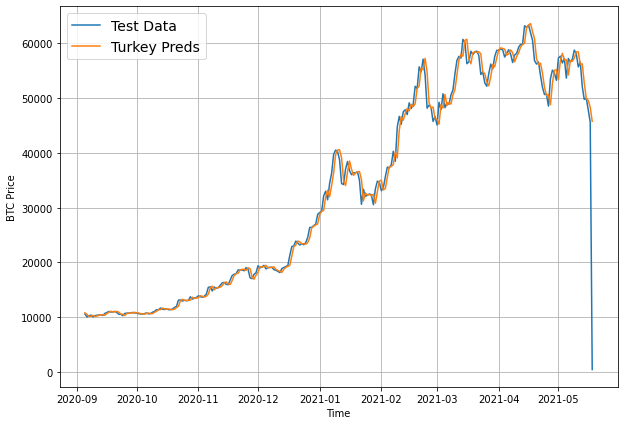

In [266]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], values=btc_price_turkey[-len(y_test):], label="Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], values=turkey_preds, label="Turkey Preds", start=offset);

# TODO: Exercises

* Does scaling the data help for multivariate data? (e.g. getting all of the values between 0 & 1) 

# TODO: Extra-curriculum

* Evaluation metrics - https://otexts.com/fpp2/accuracy.html 
* 